In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

## Turkey

In [3]:
data = pd.read_csv('/Users/emily_yang/Desktop/ACP Dataset/Turkey prices.csv')

In [4]:
data

,id,banner,fullname,size,edited_at,current_price_ea,city,province
0,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-03-18 23:06:14.046,7.48,Winnipeg,MB
1,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-03-25 23:06:13.364,7.48,Winnipeg,MB
2,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-04-01 23:06:13.449,7.48,Winnipeg,MB
3,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-04-16 04:51:03.249,7.48,Winnipeg,MB
4,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-04-16 04:51:03.249,7.48,Winnipeg,MB
...,...,...,...,...,...,...,...,...
774920,49773,Roth,FRESH WHOLE TURKEY - LB,lb,2024-08-23 22:04:19.314,3.99,Salem,OR
774921,49773,Roth,FRESH WHOLE TURKEY - LB,lb,2024-08-29 20:41:15.046,3.99,Salem,OR
774922,49773,Roth,FRESH WHOLE TURKEY - LB,lb,2024-12-20 00:01:11.393,4.49,Stayton,OR
774923,49773,Roth,FRESH WHOLE TURKEY - LB,lb,2024-12-26 22:27:32.913,4.49,Stayton,OR


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774925 entries, 0 to 774924
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                774925 non-null  int64  
 1   banner            774925 non-null  object 
 2   fullname          774925 non-null  object 
 3   size              745342 non-null  object 
 4   edited_at         774925 non-null  object 
 5   current_price_ea  774925 non-null  float64
 6   city              774925 non-null  object 
 7   province          774925 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 47.3+ MB


In [6]:
# Convert date and province columns
data["edited_at"] = pd.to_datetime(data["edited_at"])
province_mapping = {
    "Alberta": "AB",
    "Ontario": "ON",
    "British Columbia": "BC",
    "New Brunswick": "NB",
    "Newfoundland and Labrador": "NL",
    "Nova Scotia": "NS",
    "Northwest Territories": "NT",
    "Prince Edward Island": "PE",
    "Saskatchewan": "SK",
    "Manitoba": "MB",
    "Quebec": "QC",
    "Yukon": "YT",
    "Nunavut": "NU"
}
data["province"] = data["province"].replace(province_mapping)

In [7]:
data.head()

,id,banner,fullname,size,edited_at,current_price_ea,city,province
0,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-03-18 23:06:14.046,7.48,Winnipeg,MB
1,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-03-25 23:06:13.364,7.48,Winnipeg,MB
2,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-04-01 23:06:13.449,7.48,Winnipeg,MB
3,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-04-16 04:51:03.249,7.48,Winnipeg,MB
4,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-04-16 04:51:03.249,7.48,Winnipeg,MB


In [8]:
# Convert date columns
data["edited_at"] = pd.to_datetime(data["edited_at"])

In [9]:
null_values = data.isnull().sum()
null_values

id                      0
banner                  0
fullname                0
size                29583
edited_at               0
current_price_ea        0
city                    0
province                0
dtype: int64

In [10]:
# Delete duplicates
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 544223 entries, 0 to 774924
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                544223 non-null  int64         
 1   banner            544223 non-null  object        
 2   fullname          544223 non-null  object        
 3   size              526509 non-null  object        
 4   edited_at         544223 non-null  datetime64[ns]
 5   current_price_ea  544223 non-null  float64       
 6   city              544223 non-null  object        
 7   province          544223 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 37.4+ MB


In [11]:
product_count = data["id"].nunique()
print(f"Total unique products: {product_count}")

Total unique products: 85


In [12]:
# Check for different unit formats in the size column
unique_sizes = data["size"].dropna().unique()
unique_sizes

array(['422 Gram', '4 kg', '6.0', '1.8 kg', '$8.29/1lb $18.28/1kg', '0 ',
       '454 g', '0.58', '5.32', '1 ea', '0.47', '3-5 kg',
       '$12.10/1kg $5.49/1lb', '6 kg', '$6.19/1lb $13.65/1kg',
       '$11.00/1kg $4.99/1lb', '$11.66/1kg $5.29/1lb', '$34.90/1kg',
       '0.5', '$10.99/1lb $24.23/1kg', '448 g', '454g', '1 kg',
       '$17.61/1kg $7.99/1lb', '$12.99/1lb $28.64/1kg', '/lb $4.34/kg',
       '4', '6', '16 oz', '2 lb', 'lb', '1ct', '1 lb', '1lb', 'ea',
       '1 lbr / 16 oz'], dtype=object)

In [13]:
# Iterate through the list of unique_sizes, checking each entry that contains a dollar sign
inconsistent_prices = []

for size in unique_sizes:
    # If the entry contains dollar signs
    if "$" in size:
        # Extraction prices and units
        prices = re.findall(r"\$(\d+(\.\d+)?)", size)  # Matching prices
        units = re.findall(r"(\d+(\.\d+)?)([a-zA-Z]+)", size)  # Matching values and units

        # If multiple prices and units are extracted
        if len(prices) == 2 and len(units) == 2:
            price_1, unit_1 = float(prices[0][0]), units[0][2]
            price_2, unit_2 = float(prices[1][0]), units[1][2]

            # Convert price to price per kilogram
            if 'lb' in unit_1.lower():
                price_1_per_kg = price_1 / 0.453592  # 1 lb = 0.453592 kg
            elif 'kg' in unit_1.lower():
                price_1_per_kg = price_1
            else:
                price_1_per_kg = price_1

            if 'lb' in unit_2.lower():
                price_2_per_kg = price_2 / 0.453592  # 1 lb = 0.453592 kg
            elif 'kg' in unit_2.lower():
                price_2_per_kg = price_2
            else:
                price_2_per_kg = price_2

            # Compare two converted prices for consistency
            if not np.isclose(price_1_per_kg, price_2_per_kg, atol=0.01):  # Small tolerances allowed
                inconsistent_prices.append(size)

# Output inconsistent entries
for item in inconsistent_prices:
    print(item)

In [14]:
# Unit conversion dictionary (all converted to grams)
unit_conversions = {
    'lb': 453.592,
    'kg': 1000,
    'gram': 1,
    'g': 1,
    'oz': 28.3495,
    'ea': 0,
}

weights = []
unit_prices = []

# Iterate over the ‘size’ column in the entire DataFrame
for idx, size in enumerate(data['size']):
    # Get the current_price_ea of the current row.
    current_price = data.iloc[idx]["current_price_ea"]

    size = str(size).strip()  # Ensure that size is a string and remove the leading and trailing spaces

    # Handling of anomalous data
    if re.fullmatch(r"\d+(\.\d+)?", size):  # Plain numbers, defaults to kg
        weight_in_grams = float(size) * 1000  # Assumed to be in kg
        weights.append(weight_in_grams)
        unit_prices.append(current_price / weight_in_grams if weight_in_grams > 0 else 0)
        continue

    # Process unit price information (contains `$`)
    if "$" in size:

        if "/lb $4.34/kg" == size:
            price = 4.34 / 1000
            unit_prices.append(price)
            weights.append(current_price / price)
            continue

        price_match = re.search(r"\$(\d+(\.\d+)?)", size)  # Extract **First** Price
        unit_match = re.search(r"(\d+(\.\d+)?)[ ]?([a-zA-Z]+)", size)  # Compatible with spaces/no spaces

        if price_match and unit_match:
            price = float(price_match.group(1))  # of units withdrawn
            weight_value = float(unit_match.group(1))  # Extraction of weight values
            unit = unit_match.group(3).lower()  # Extract units and convert to lower case

            if unit in unit_conversions:
                weight = current_price / price * unit_conversions[unit]  # Calculated weight (g)
                weights.append(weight)
                unit_prices.append(price / unit_conversions[unit])  # Calculated unit price ($/g)
            else:
                weights.append(0)
                unit_prices.append(0)
        else:
            weights.append(0)
            unit_prices.append(0)

    elif "1 lbr / 16 oz" == size:
        price = current_price / 453.592
        unit_prices.append(price)
        weights.append(453.592)
        continue

    else:
        if "454g" == size:
            price = current_price / 454
            unit_prices.append(price)
            weights.append(454)
            continue

        # Processing of weight information (without `$` but with weight and units)
        weight_match = re.match(r"(\d+(\.\d+)?)[ ]?([a-zA-Z]+)?", size)

        if weight_match:
            weight_value = float(weight_match.group(1))
            unit = weight_match.group(3).lower() if weight_match.group(3) else "kg"  # Default kg

            if unit in unit_conversions:
                weight_in_grams = weight_value * unit_conversions[unit]  # Converted to grams
                weights.append(weight_in_grams)
                unit_prices.append(current_price / weight_in_grams if weight_in_grams > 0 else 0)
            else:
                weights.append(0)
                unit_prices.append(0)
        else:
            weights.append(0)
            unit_prices.append(0)

# Add the calculated weight and unit_price to the DataFrame
data['weight'] = weights
data['unit_price'] = unit_prices

/var/folders/kt/_fvc3g1522bdv67mfs7scqvr0000gn/T/ipykernel_16113/2836240954.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weight'] = weights
/var/folders/kt/_fvc3g1522bdv67mfs7scqvr0000gn/T/ipykernel_16113/2836240954.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['unit_price'] = unit_prices


In [15]:
# Filter rows with weight or unit_price of 0
zero_weight_or_price = data[(data['weight'] == 0) | (data['unit_price'] == 0)]
unique_problematic_sizes = zero_weight_or_price['size'].dropna().unique()
print("There is a unique size value for weight or unit_price = 0:")
print(unique_problematic_sizes)
zero_weight_or_price.shape[0] / data.shape[0]

There is a unique size value for weight or unit_price = 0:
['0 ' '1 ea' '454g' '3-5 kg' 'lb' '1ct' 'ea']


0.12264641516437196

In [16]:
# Filter rows with non-zero weight or unit price
selected_data = data[(data['weight'] > 0) & (data['unit_price'] > 0)]
product_count = selected_data["id"].nunique()
print(f"Total unique products: {product_count}")

Total unique products: 47


In [22]:
data

,id,banner,fullname,size,edited_at,current_price_ea,city,province,weight,unit_price
0,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-03-18 23:06:14.046,7.48,Winnipeg,MB,422.0,0.017725
1,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-03-25 23:06:13.364,7.48,Winnipeg,MB,422.0,0.017725
2,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-04-01 23:06:13.449,7.48,Winnipeg,MB,422.0,0.017725
3,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-04-16 04:51:03.249,7.48,Winnipeg,MB,422.0,0.017725
5,21619,Save-on-Foods,"Western Canadian Turkey Ground Thigh , Extra L...",422 Gram,2020-04-22 23:06:04.867,7.48,Winnipeg,MB,422.0,0.017725
...,...,...,...,...,...,...,...,...,...,...
774920,49773,Roth,FRESH WHOLE TURKEY - LB,lb,2024-08-23 22:04:19.314,3.99,Salem,OR,0.0,0.000000
774921,49773,Roth,FRESH WHOLE TURKEY - LB,lb,2024-08-29 20:41:15.046,3.99,Salem,OR,0.0,0.000000
774922,49773,Roth,FRESH WHOLE TURKEY - LB,lb,2024-12-20 00:01:11.393,4.49,Stayton,OR,0.0,0.000000
774923,49773,Roth,FRESH WHOLE TURKEY - LB,lb,2024-12-26 22:27:32.913,4.49,Stayton,OR,0.0,0.000000


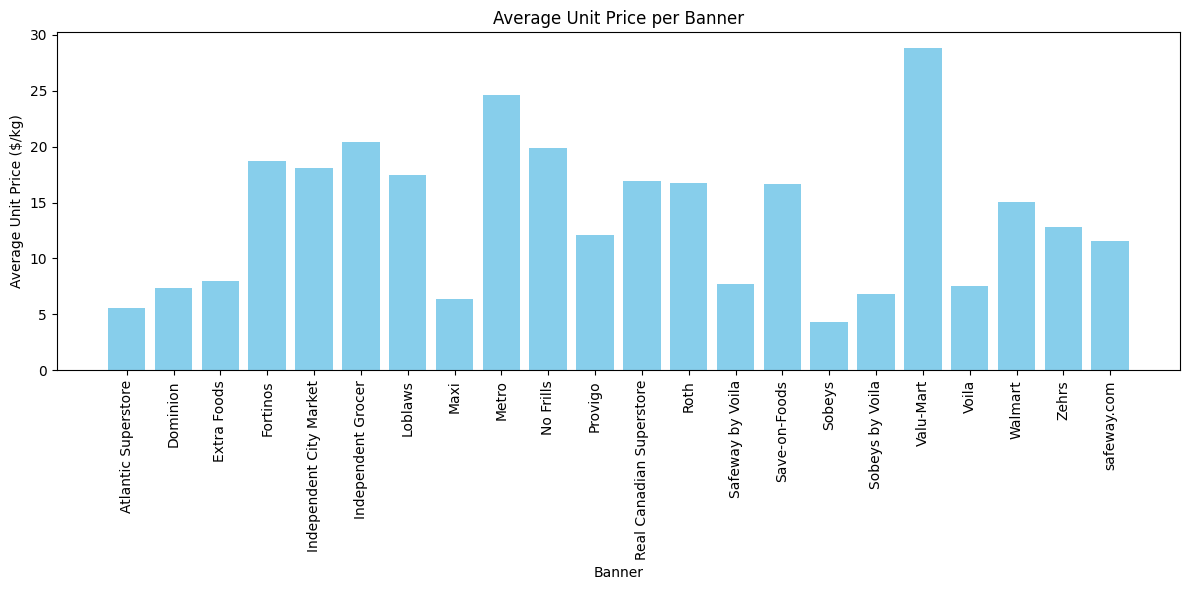

In [18]:
# Calculate the average unit price of all products under each merchant (banner)
avg_banner_prices = selected_data.groupby('banner')['unit_price'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(avg_banner_prices['banner'], avg_banner_prices['unit_price'] * 1000, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Banner')
plt.ylabel('Average Unit Price ($/kg)')
plt.title('Average Unit Price per Banner')
plt.tight_layout()
plt.show()

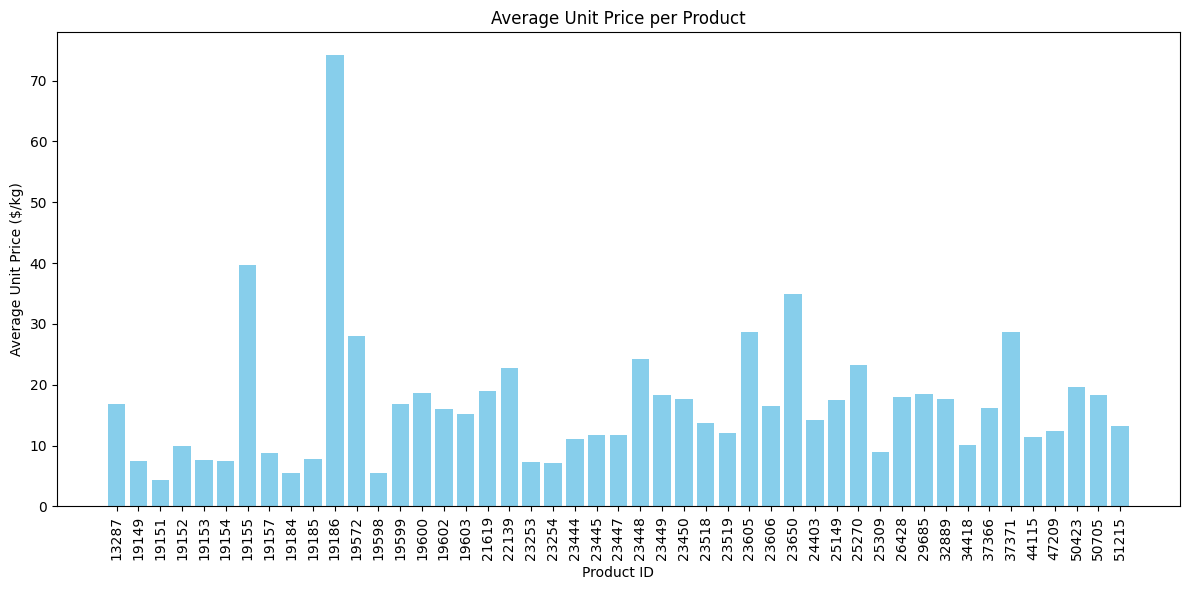

In [19]:
# Calculate the average unit price for each product
avg_product_prices = selected_data.groupby('id')['unit_price'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(avg_product_prices['id'].astype(str), avg_product_prices['unit_price'] * 1000, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Product ID')
plt.ylabel('Average Unit Price ($/kg)')
plt.title('Average Unit Price per Product')
plt.tight_layout()
plt.show()

/var/folders/kt/_fvc3g1522bdv67mfs7scqvr0000gn/T/ipykernel_16113/2418069986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['time_period'] = selected_data['edited_at'].dt.to_period('M')


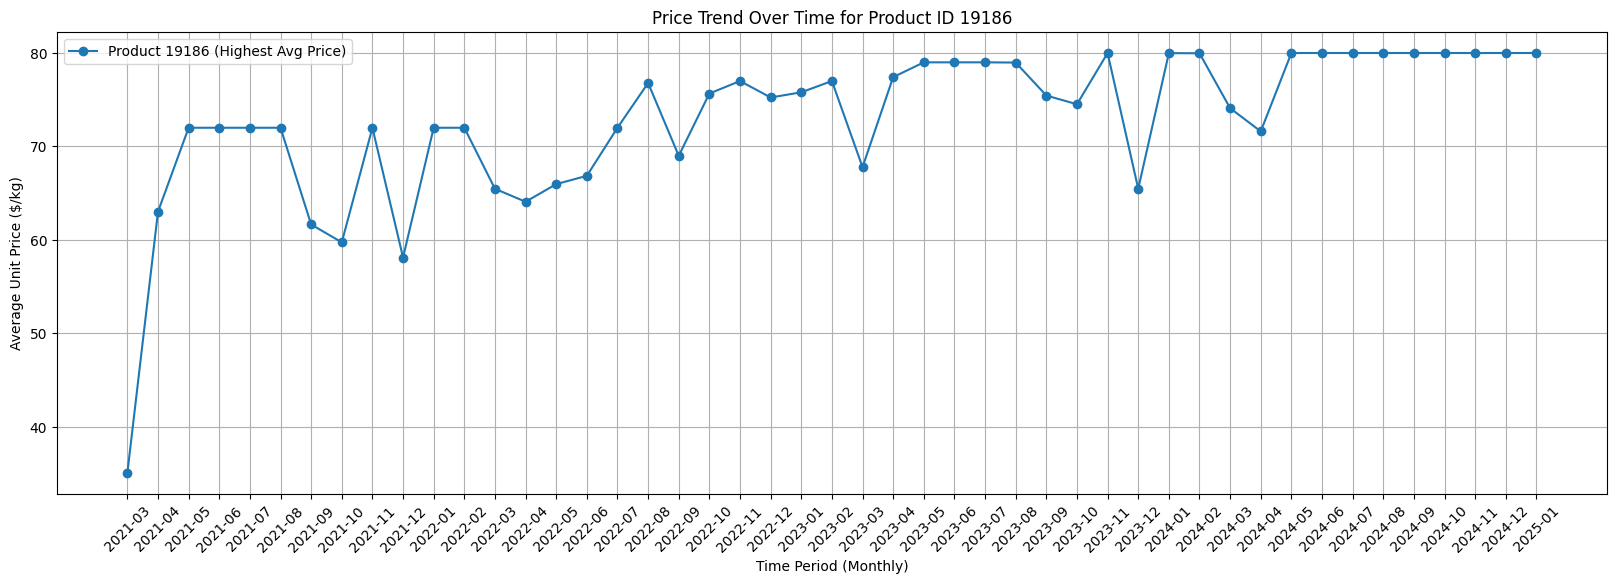

In [20]:
# Setting time intervals (averaging prices on a monthly basis)
selected_data['time_period'] = selected_data['edited_at'].dt.to_period('M')

# Directly calculate the total average unit price for each product to find the commodity ID with the highest historical average price
most_expensive_product_id = selected_data.groupby('id')['unit_price'].mean().idxmax()

# Sift through the data for the item
most_expensive_product_data = selected_data[selected_data['id'] == most_expensive_product_id]

# Calculate the average price of the product in each month (across cities)
avg_price_per_time = most_expensive_product_data.groupby('time_period')['unit_price'].mean().reset_index()

plt.figure(figsize=(20, 6))
plt.plot(avg_price_per_time['time_period'].astype(str), avg_price_per_time['unit_price'] * 1000, marker='o', linestyle='-',
         label=f'Product {most_expensive_product_id} (Highest Avg Price)')
plt.xlabel('Time Period (Monthly)')
plt.ylabel('Average Unit Price ($/kg)')
plt.title(f'Price Trend Over Time for Product ID {most_expensive_product_id}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

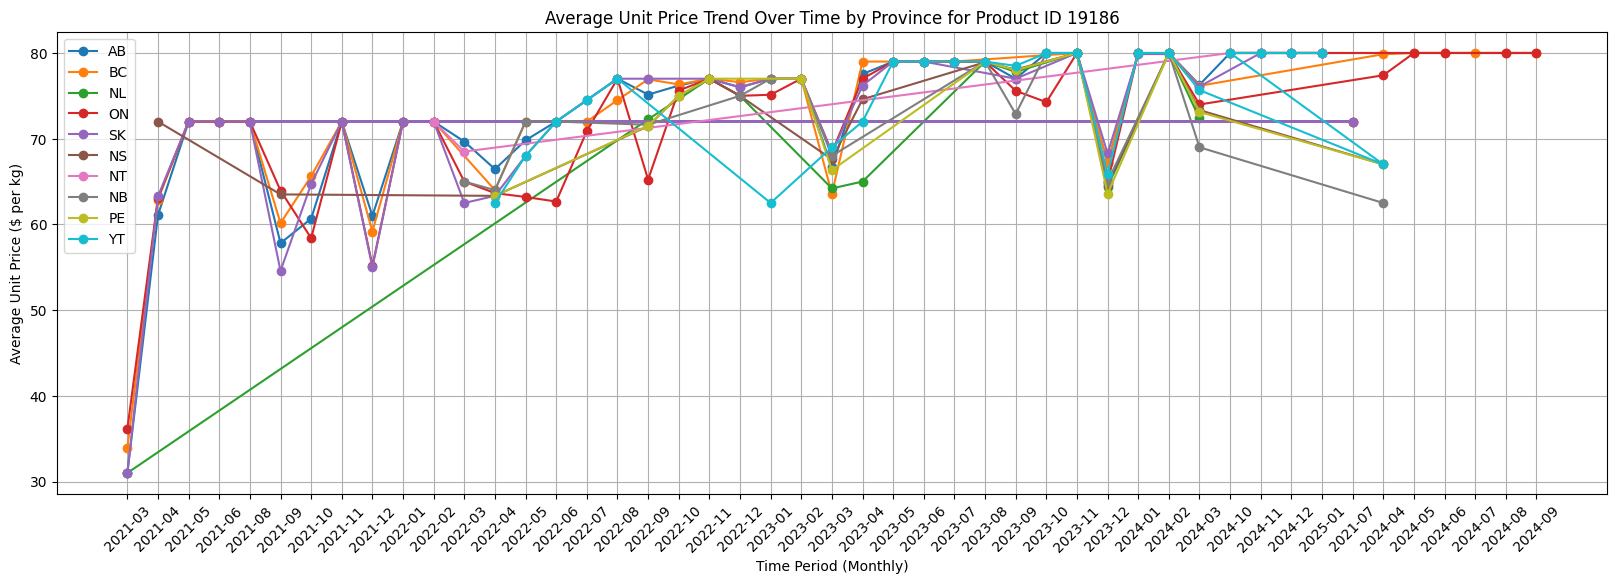

In [21]:
# Calculate the average price of the product in each province over time
most_expensive_product_data = selected_data[selected_data['id'] == most_expensive_product_id]
avg_price_per_province_time = most_expensive_product_data.groupby(['time_period', 'province'])['unit_price'].mean().reset_index()

plt.figure(figsize=(20, 6))
for province in avg_price_per_province_time['province'].unique():
    subset = avg_price_per_province_time[avg_price_per_province_time['province'] == province]
    plt.plot(subset['time_period'].astype(str), subset['unit_price'] * 1000, marker='o', linestyle='-', label=province)

plt.xlabel('Time Period (Monthly)')
plt.ylabel('Average Unit Price ($ per kg)')  # Units adjusted to $/kg
plt.title(f'Average Unit Price Trend Over Time by Province for Product ID {most_expensive_product_id}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()